# Phase 2 - Milestone 1

**Ediashta Revindra Amirussalam**

FTDS-020-RMT


## Objective


Tujuan dari project ini adalah membantu perusahaan Apotik, HaiMeds, untuk meminimalisir risiko churn pelanggan. Churn adalah kondisi di mana pelanggan berhenti menggunakan produk atau layanan perusahaan. Untuk mencapai tujuan ini sebagai data analyst, lakukan sebuah analisis data dan pemodelan untuk melakukan prediksi klasifikasi Churn pelanggan

Pada project ini akan digunakan 2 jenis model ANN yaitu:
- Sequential ANN
- Functional ANN
  
Kedua model tersebut akan diambil salah satu model terbaik berdasarkan metrics Recall, dikarenakan kita akan mencoba mengurangi prediksi False Negative, yang berarti pengguna yang churn diprediksi sebagai tidak churn, sehingga perusahaan berpotensi kehilangan customer.

## 00 - Import Libraries


In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle

## 01 - Data Loading


In [132]:
data = pd.read_csv("./churn.csv")

In [133]:
data.head()

,user_id,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,9f420209e7d129f3,29,F,NaN,No Membership,2017-04-05,Yes,Without Offers,NaN,Wi-Fi,...,1184.49,38604.69,10.0,627.48,Yes,Yes,Yes,No Information Available,Poor Website,1
1,ac6e97806267549e,50,M,NaN,Basic Membership,2017-03-31,Yes,Without Offers,Desktop,Fiber_Optic,...,338.15,7665.66,17.0,575.97,Yes,No,Yes,No Information Available,Poor Customer Service,1
2,a6aa19b1580eed4e,26,F,City,Silver Membership,2017-02-11,NaN,Credit/Debit Card Offers,NaN,Fiber_Optic,...,235.14,37671.69,5.0,767.93,Yes,No,Yes,No Information Available,Too many ads,0
3,aeee343277211c2f,63,F,Village,No Membership,2015-12-23,No,Credit/Debit Card Offers,Desktop,Fiber_Optic,...,56.67,15678.14,11.0,590.22,No,Yes,No,Not Applicable,Too many ads,1
4,82448b5c8ce6390c,64,M,Town,Silver Membership,2015-03-20,NaN,Gift Vouchers/Coupons,Smartphone,Wi-Fi,...,153.99,8422.68,0.0,722.04,Yes,No,No,Not Applicable,Poor Product Quality,0


In [134]:
data_copy = data.copy()

## 02 - EDA


In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37010 entries, 0 to 37009
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   user_id                       37010 non-null  object 
 1   age                           37010 non-null  int64  
 2   gender                        36951 non-null  object 
 3   region_category               31579 non-null  object 
 4   membership_category           37010 non-null  object 
 5   joining_date                  37010 non-null  object 
 6   joined_through_referral       31568 non-null  object 
 7   preferred_offer_types         36722 non-null  object 
 8   medium_of_operation           31615 non-null  object 
 9   internet_option               37010 non-null  object 
 10  last_visit_time               37010 non-null  object 
 11  days_since_last_login         37010 non-null  int64  
 12  avg_time_spent                37010 non-null  float64
 13  a

Pada dataset ini terdapat 17 kolom dan 37010 baris data dengan keterangan sebagai berikut

 Column<br><br> | Description <br><br>| -- | Column<br><br> | Description<br><br>
| --- | --- | -- | --- | --- |
| `user_id` | ID of a customer | -- | `avg_time_spent` | Average time spent by a customer on the website |
| `age` | Age of a customer | -- | `avg_transaction_value` | Average transaction value of a customer |
| `gender` | Gender of a customer | -- | `avg_frequency_login_days` | Number of times a customer has logged in to the website |
| `region_category` | Region that a customer belongs to | -- | `points_in_wallet` | Points awarded to a customer on each transaction |
| `membership_category` | Category of the membership that a customer is using | -- | `used_special_discount` | Whether a customer uses special discounts offered |
| `joining_date` | Date when a customer became a member | -- | `offer_application_preference` | Whether a customer prefers offers |
| `joined_through referral` | Whether a customer joined using any referral code or ID | -- | `past_complaint` | Whether a customer has raised any complaints |
| `preferred_offer types` | Type of offer that a customer prefers | -- | `complaint_status` | Whether the complaints raised by a customer was resolved |
| `medium_of operation` | Medium of operation that a customer uses for transactions | -- | `feedback` | Feedback provided by a customer |
| `internet_option` | Type of internet service a customer uses | -- | **`churn_risk_score`** | Churn score <br><br> **`0` : Not churn <br> `1` : Churn** |
| `last_visit_time` | The last time a customer visited the website | -- 
| `days_since_last_login` | Number of days since a customer last logged into the website | -- 












In [136]:
data.describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score
count,37010.000000,37010.000000,37010.000000,37010.000000,37010.000000,37010.000000,37010.000000
mean,37.120697,-41.943502,279.201356,29272.430216,14.659540,623.590885,0.540881
std,15.866834,228.875324,330.017336,19445.963492,9.478756,270.218956,0.498333
min,10.000000,-999.000000,0.000000,800.460000,0.000000,0.000000,0.000000
25%,23.000000,8.000000,60.122500,14177.835000,7.000000,574.220000,0.000000
50%,37.000000,12.000000,161.770000,27554.485000,14.000000,680.400000,1.000000
75%,51.000000,16.000000,356.525000,40858.672500,22.000000,756.990000,1.000000
max,64.000000,26.000000,3235.578521,99914.050000,73.061995,2069.069761,1.000000


* Rata-rata usia pengguna adalah 37 Tahun, dengan rata-rata transaksi 29.272 Ribu Rupiah
* Rata-rata pengguna membuka aplikasi setiap 14 hari sekali dan rata-rata menghabiskan waktu sebanyak 279 menit secara total

In [137]:
data.isnull().sum()

user_id                            0
age                                0
gender                            59
region_category                 5431
membership_category                0
joining_date                       0
joined_through_referral         5442
preferred_offer_types            288
medium_of_operation             5395
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                   0
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

Terdapat banyak data null yang dapat kita handle pada feature engineering nantinya

In [138]:
data.duplicated().sum()

18

Terdapat 18 data duplicate yang dapat kita drop

In [139]:
data[data.duplicated()].head()

,user_id,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
3321,9f97903015fd0580,29,M,NaN,Silver Membership,2017-10-31,NaN,Credit/Debit Card Offers,Desktop,Fiber_Optic,...,67.850000,1228.39,16.0,712.30,Yes,No,No,Not Applicable,No reason specified,0
9505,b0045613327d17fb,36,F,City,Platinum Membership,2016-03-07,No,Credit/Debit Card Offers,Desktop,Wi-Fi,...,210.640000,46466.03,9.0,716.45,No,Yes,No,Not Applicable,Too many ads,0
11478,9ba8bf4d1e50100c,47,F,Town,Gold Membership,2016-07-10,No,Credit/Debit Card Offers,Both,Fiber_Optic,...,497.320000,15082.13,11.0,730.34,No,Yes,Yes,Unsolved,No reason specified,0
12589,8f39faa74b6607e7,26,F,City,Premium Membership,2015-10-05,NaN,Credit/Debit Card Offers,NaN,Fiber_Optic,...,116.140000,26377.39,0.0,710.31,Yes,No,Yes,Solved,No reason specified,0
14840,859745861c61ebef,35,M,City,Silver Membership,2016-03-27,Yes,Gift Vouchers/Coupons,Smartphone,Fiber_Optic,...,1064.763315,42483.66,28.0,702.11,No,Yes,Yes,Solved in Follow-up,Too many ads,1


In [140]:
data.drop_duplicates(inplace=True)

data.shape

(36992, 22)

Kita berhasil drop data duplicate yang menghasilkan jumlah baris data akhir sebanyak 36.992

In [141]:
num_col = data.select_dtypes(include=np.number).columns.tolist()
cat_col = data.select_dtypes(include=object).columns.tolist()

Kemudian kita bisa memisahkan kolom numerik dan kategorikal untuk melakukan eksplorasi terhadap persebaran data

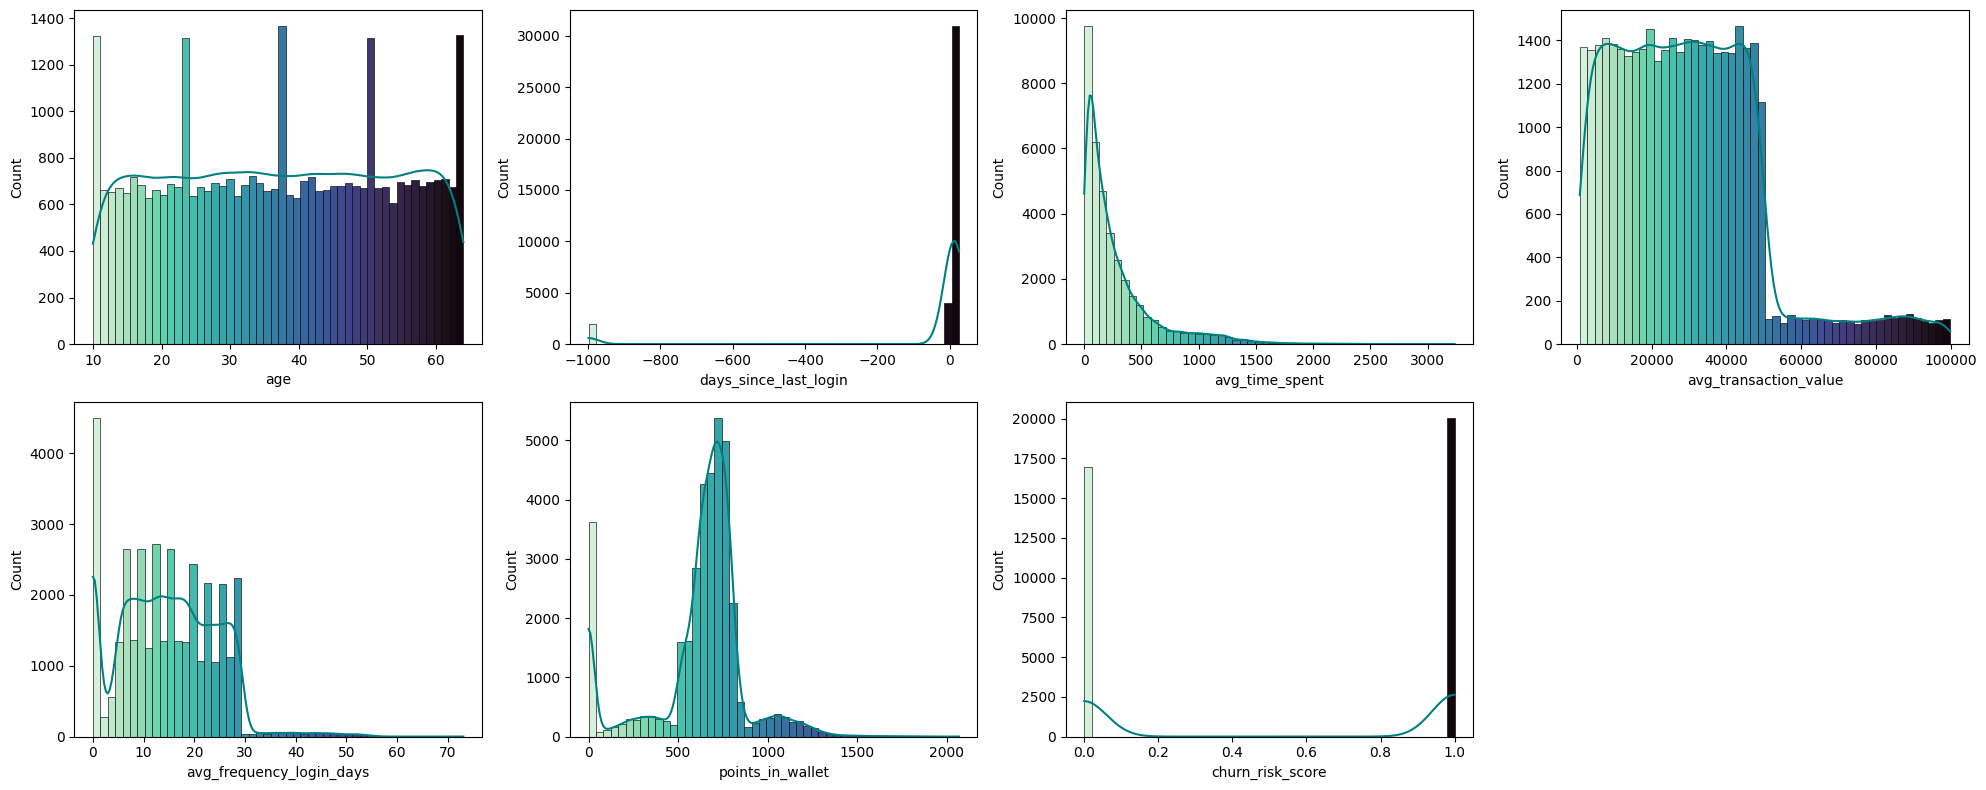

In [142]:
# check num distribution
plt.figure(figsize=(20, 8))

palette = sns.color_palette("mako_r", 50)

index = 1

for i in num_col:
    plt.subplot(2, 4, index)
    plot = sns.histplot(data=data, x=i, kde=True, bins=50, color="teal")

    for bin_, i in zip(plot.patches, palette):
        bin_.set_facecolor(i)

    index = index + 1

plt.tight_layout()

Didapatkan insight sebagai berikut:
* Pada aplikasi ini, persebaran umur epngguna merata mulai dari 10 tahun hingga 60-an tahun
* Banyak pengguna yang menghabiskan waktu menggunakan aplikasi dibawah 500 menit, dan terdapat beberapa yang menghabiskan waktu hingga 3000 menit
* Nilai rata-rata transaksi dapat dikatakan skewed, karena mayoritas transaksi berada pada angka dibawah 40.000 Rupiah
* Jumlah Churn Risk 0 dan 1 tidak terlalu berbeda signifikan (>50%) sehingga kita tidak perlu lakukan re-sampling pada data ini

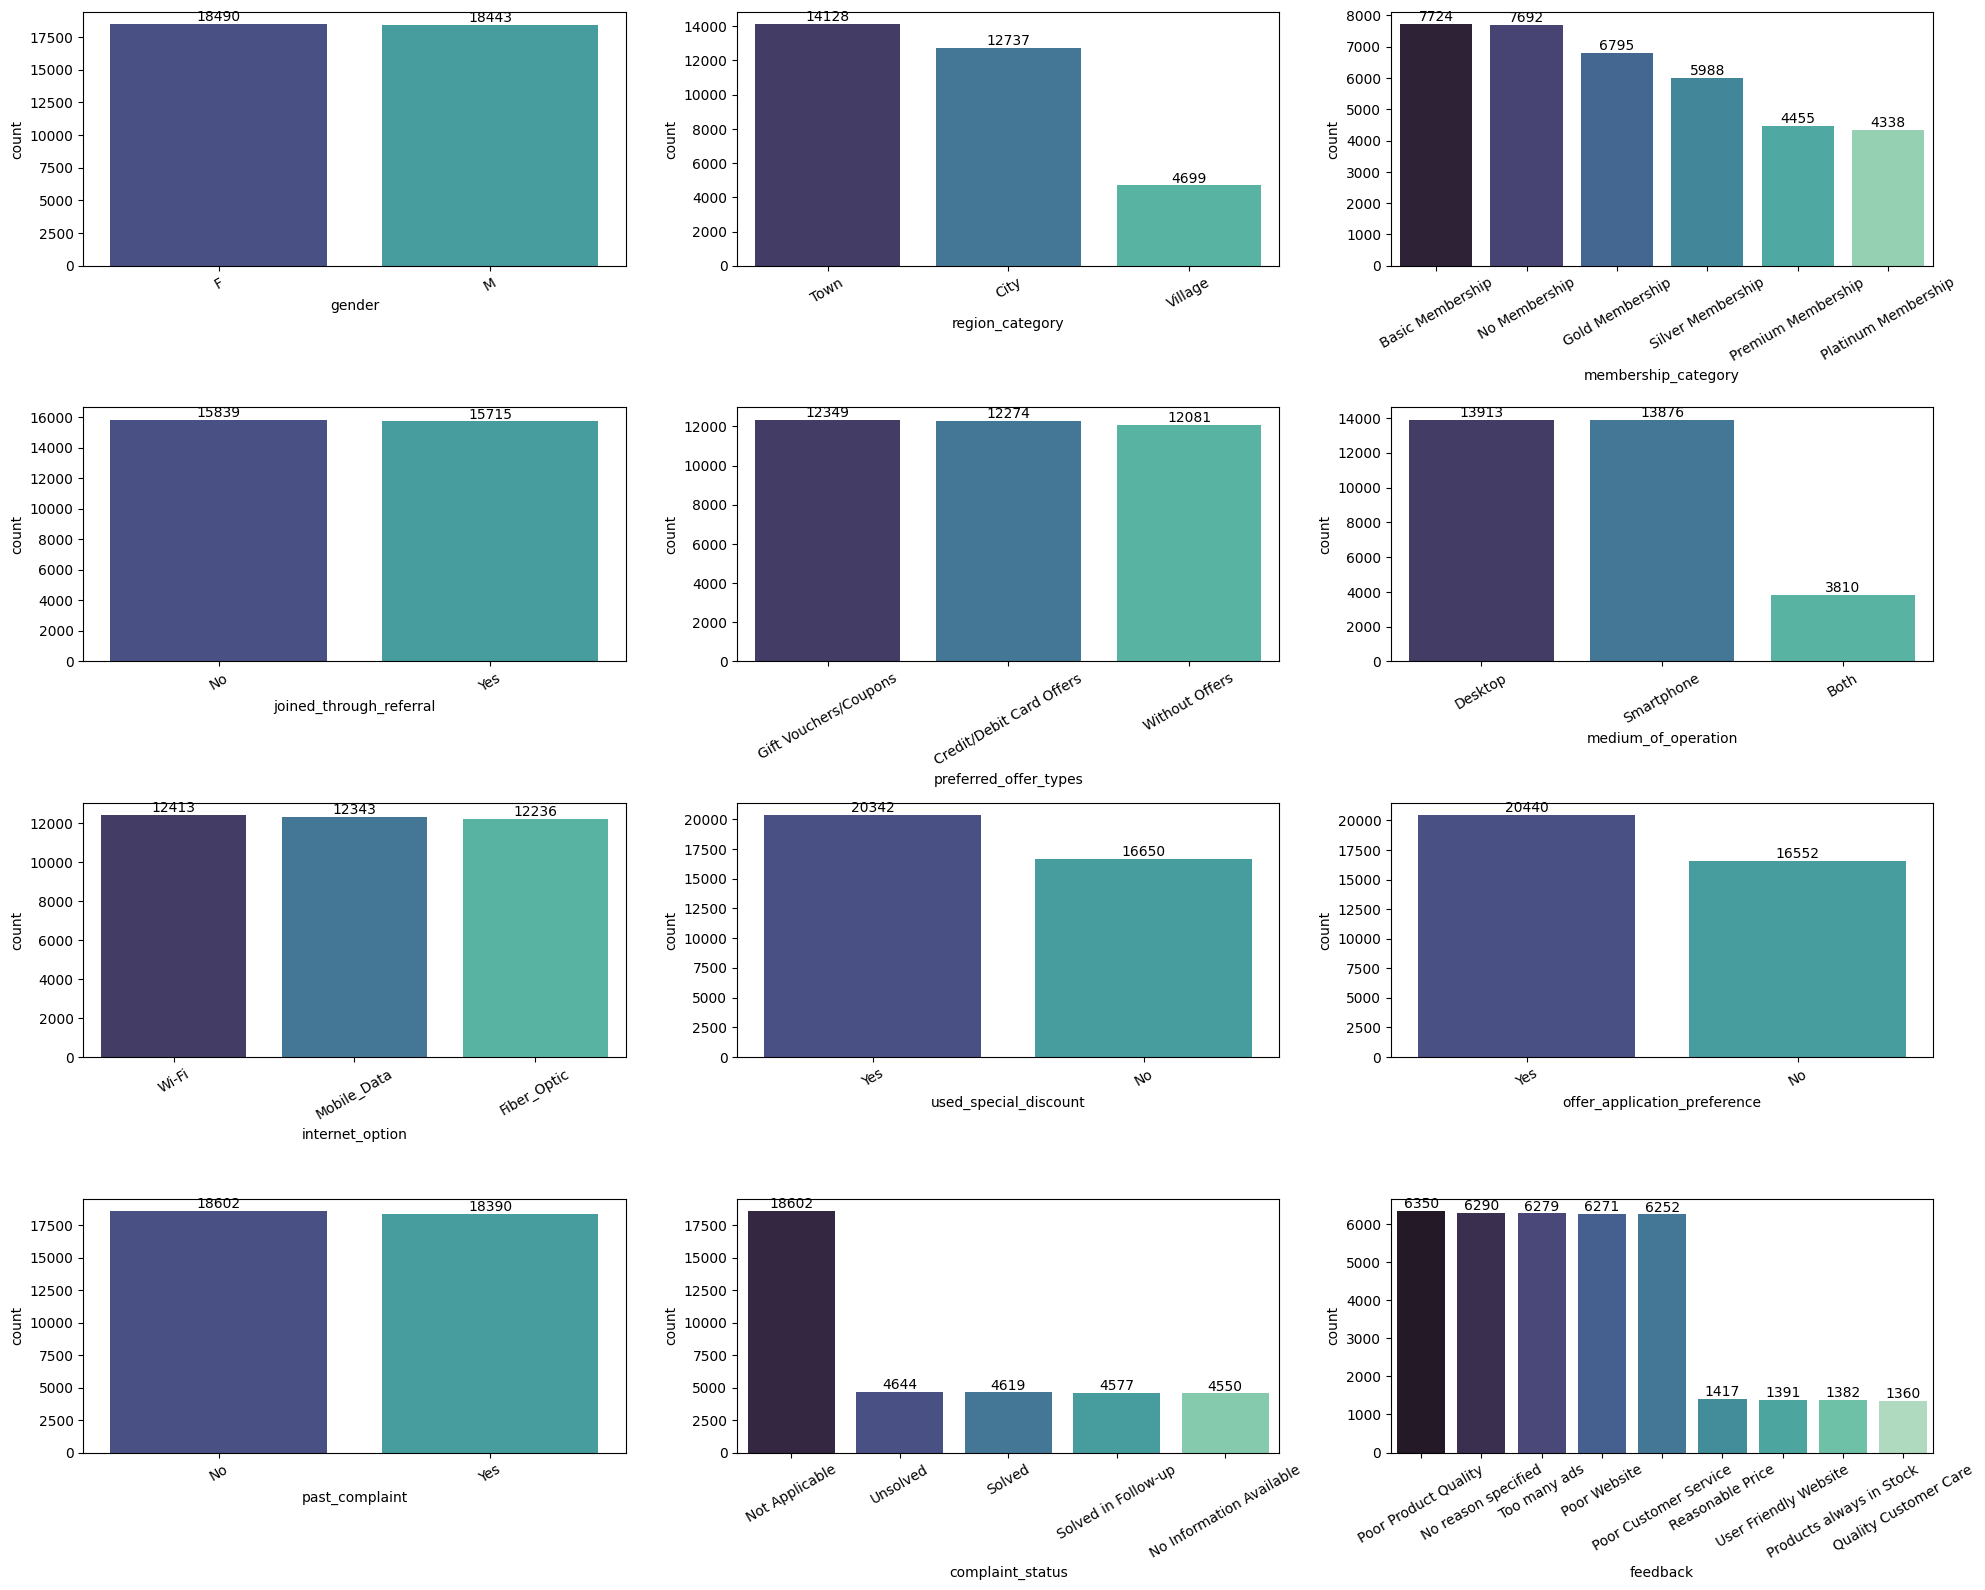

In [143]:
# check cat distribution
plt.figure(figsize=(20, 16))

palette = sns.color_palette("mako_r", 50)

index = 1

for i in cat_col:
    if i != "user_id" and i != "joining_date" and i != "last_visit_time":
        plt.subplot(4, 3, index)
        plot = sns.countplot(
            data=data, x=i, palette="mako", order=data[i].value_counts().index
        )
        plt.bar_label(
            container=plot.containers[0], labels=data[i].value_counts().values
        )
        plt.xticks(rotation=30)
    else:
        index = index - 1

    index = index + 1

plt.tight_layout()

* Pada data numerikal dapat dilihat bahwa banyak data yang terdistribusi secara normal, atau hanya sedikit data yang memiliki rasio lebih besar dibandingkan data lainnya
* Pada kolom feedback, dapat dilihat bahwa lebih banyak pengguna yang memberikan feedback negatif ketimbang feedback positif

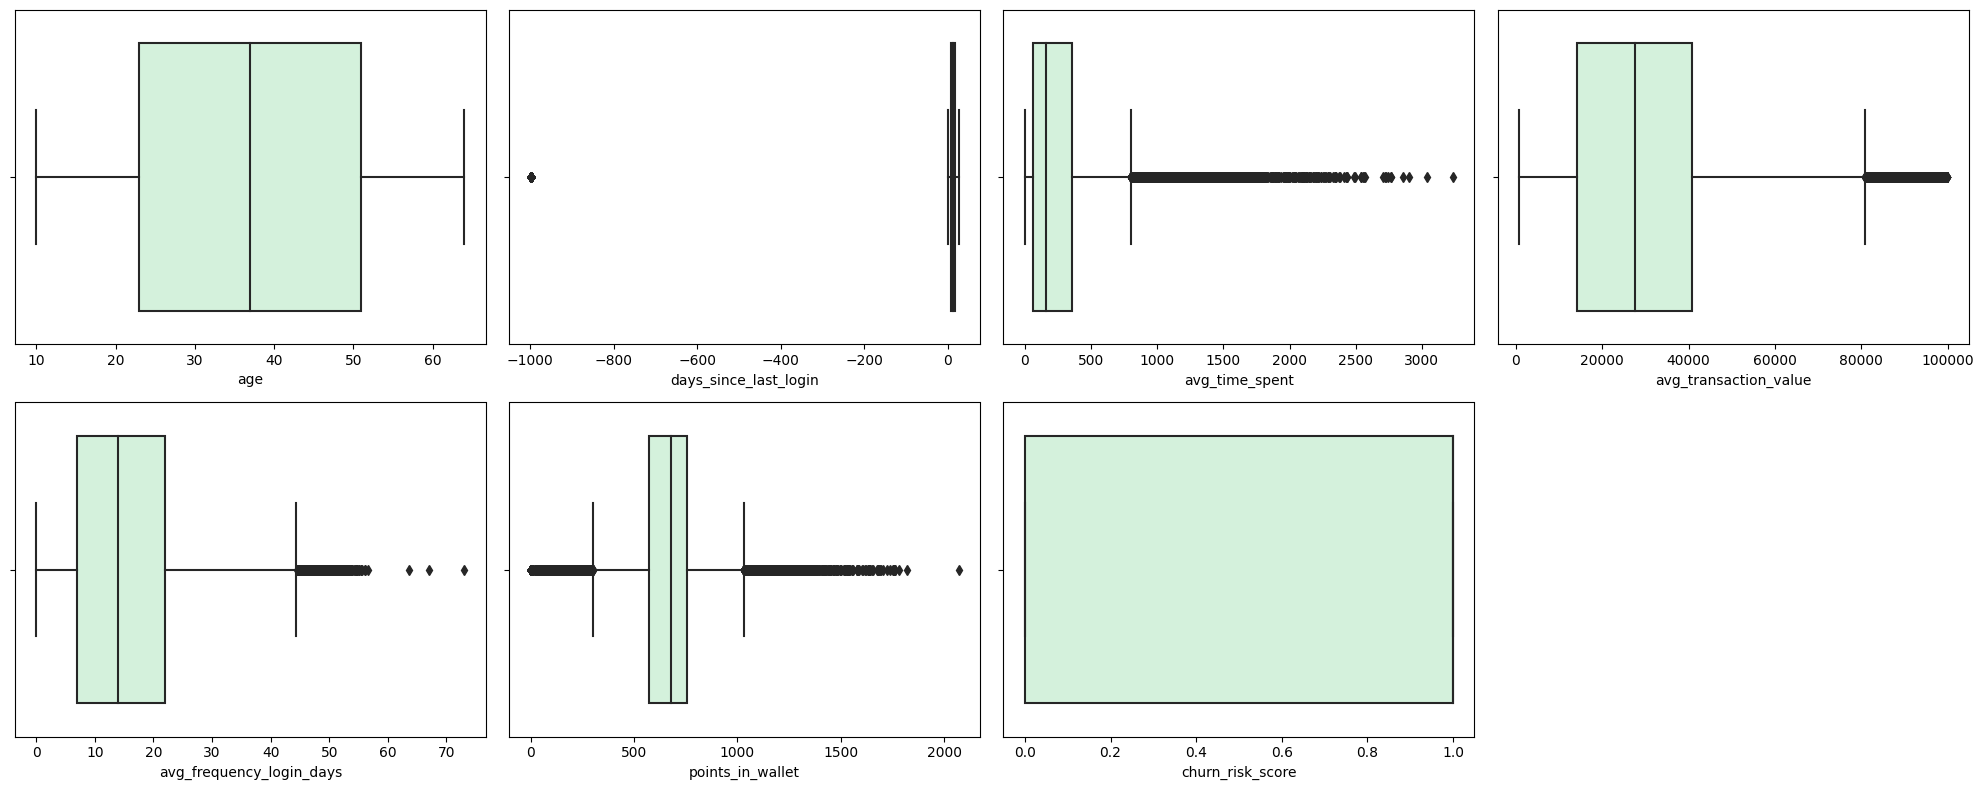

In [144]:
# check num distribution
plt.figure(figsize=(20, 8))

index = 1

for i in num_col:
    plt.subplot(2, 4, index)
    plot = sns.boxplot(data=data, x=i, color="teal")

    for bin_, i in zip(plot.patches, palette):
        bin_.set_facecolor(i)

    index = index + 1

plt.tight_layout()

Ditemukan adanya outliers pada kolom berikut:
* `days_since_last_login`
* `avg_time_spent`
* `avg_transaction_value`
* `avg_frequecy_login_days`
* `points_in_wallet`

Data-data outliers ini akan kita handle nantinya menggunakan Winsorizer Capping

Kita dapat lanjutkan pengecekan terhadap korelasi antara kolom dengan target kita, yaitu Churn Risk

In [145]:
# def cramers_v
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

Untuk data kategorikal, kita akan gunakan nilai Cramers_V untuk menentukan korelasinya

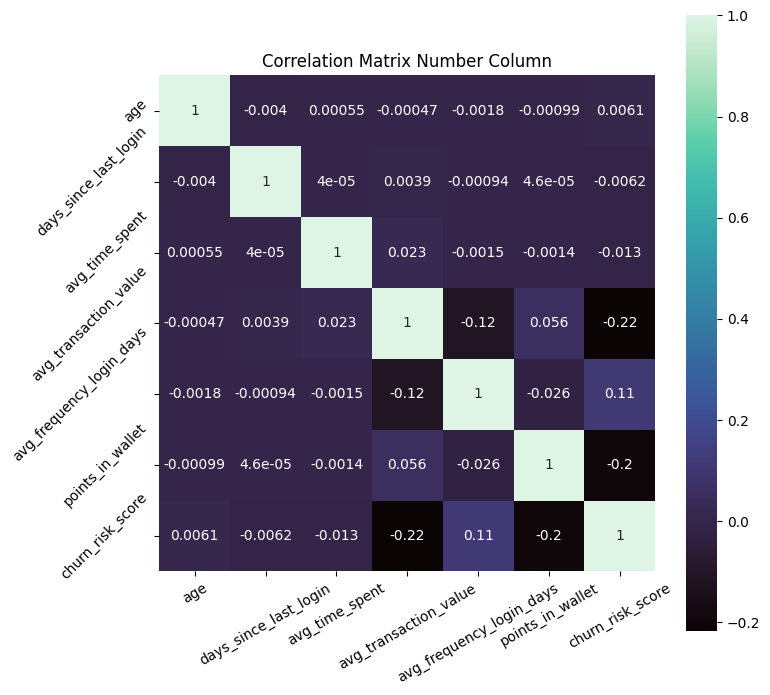

In [146]:
# check correlation

corr = data[num_col].corr(method="pearson")

plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True, cmap="mako", square=True)
plt.xticks(rotation=30)
plt.yticks(rotation=45)
plt.title("Correlation Matrix Number Column")

plt.show()

Pada kolom numerikan, terlihat bahwa kolom `age` dan `days_since_last_login` memiliki korelasi yang sangat kecil

In [147]:
# correlation for categorical
print("Correlation Categorical Columns")
for i in cat_col:
    if i != "user_id":
        print(i, " :", round(cramers_v(data[i], data["churn_risk_score"]), 4))

Correlation Categorical Columns
gender  : 0.0
region_category  : 0.0223
membership_category  : 0.7859
joining_date  : 0.0
joined_through_referral  : 0.0355
preferred_offer_types  : 0.0434
medium_of_operation  : 0.0218
internet_option  : 0.0025
last_visit_time  : 0.0604
used_special_discount  : 0.0092
offer_application_preference  : 0.0179
past_complaint  : 0.0072
complaint_status  : 0.0054
feedback  : 0.4561


Begitu pula pada data kategorikal, ditemukan bahwa `gender` serta `joining_date` tidak berpengaruh pada `churn_risk_score`

## 03 - Feature Engineering


### Feature Selection


Sesuai dengan korelasi yang telah kita observasi sebelumnya kita akan melakukan drop terhadap `gender` dan `joining_date`, sedangkan `user_id` dan `last_visit_time` seharusnya tidak berpengaruh terhadap keputusan user untuk churn

In [148]:
#drop unnecessary column
data.drop(
    columns=["user_id", "gender", "joining_date", "last_visit_time"], inplace=True
)

In [149]:
data.shape

(36992, 18)

Setelah ke-empat kolom tersebut kita drop, menyisakan 18 kolom yang akan kita gunakan sebagai fitur dan target

### Handling High Cardinality


Kemudian kita dapat melakukan pemeriksaan terhadap kardinalitas dari data kategorikal, hal ini dilakukan agar ketika dilakukan encoding menggunakan onehot, karena akan menjadikan dimensi dari dataset menjadi sangat besar

In [150]:
#check cardinality
for i in cat_col:
    if (
        i != "user_id"
        and i != "gender"
        and i != "joining_date"
        and i != "last_visit_time"
    ):
        print(i)
        print(data[i].unique())
        print("")

region_category
[nan 'City' 'Village' 'Town']

membership_category
['No Membership' 'Basic Membership' 'Silver Membership'
 'Premium Membership' 'Gold Membership' 'Platinum Membership']

joined_through_referral
['Yes' nan 'No']

preferred_offer_types
['Without Offers' 'Credit/Debit Card Offers' 'Gift Vouchers/Coupons' nan]

medium_of_operation
[nan 'Desktop' 'Smartphone' 'Both']

internet_option
['Wi-Fi' 'Fiber_Optic' 'Mobile_Data']

used_special_discount
['Yes' 'No']

offer_application_preference
['Yes' 'No']

past_complaint
['Yes' 'No']

complaint_status
['No Information Available' 'Not Applicable' 'Unsolved' 'Solved'
 'Solved in Follow-up']

feedback
['Poor Website' 'Poor Customer Service' 'Too many ads'
 'Poor Product Quality' 'No reason specified' 'Products always in Stock'
 'Reasonable Price' 'Quality Customer Care' 'User Friendly Website']



Dapat dilihat bahwa pada kolom feedback, terdapat kardinalitas yang cukup banyak, kita dapat membaginya kedalam feedback Negative, Neutral dan Positive

In [151]:
#replace value with corresponding category
feedback = []

for i in data["feedback"]:
    if i == "Poor Website":
        value = "Negative"
    elif i == "Poor Customer Service":
        value = "Negative"
    elif i == "Too many ads":
        value = "Negative"
    elif i == "Poor Product Quality":
        value = "Negative"
    elif i == "No reason specified":
        value = "Neutral"
    elif i == "Products always in Stock":
        value = "Positive"
    elif i == "Reasonable Price":
        value = "Positive"
    elif i == "Quality Customer Care":
        value = "Positive"
    elif i == "User Friendly Website":
        value = "Positive"
    feedback.append(value)

data["feedback"] = feedback

In [152]:
data["feedback"].unique()

array(['Negative', 'Neutral', 'Positive'], dtype=object)

### Split Feature and Target


Setelah kita handling cardinality, kita dapat melanjutkan membagi data menjadi Feature dan Target

In [153]:
#split value into X and y
X = data.drop(columns="churn_risk_score")
y = data["churn_risk_score"]

X.shape, y.shape

((36992, 17), (36992,))

### Split Into Train, Val and Test


Dari Feature dan Target tersebut, kita dapat membagi data menjadi data train, data validation, dan data test

In [154]:
# train test val split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=5)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=5
)

print("Train Size :", X_train.shape)
print("Val Size :", X_val.shape)
print("Test Size :", X_test.shape)

Train Size : (26633, 17)
Val Size : (6659, 17)
Test Size : (3700, 17)


### Handle Outliers


Kemudian kita akan lakukan handling outliers sesuai temuan pada EDA, kita akan menggunakan capping winsorizer dengan metode quantiles. winsorizer ini akan kita terapkan pada pipeline column transformer nantinya

In [155]:
# Create the capper

winsoriser = Winsorizer(
    capping_method="quantiles",
    tail="both",  # cap left, right or both tails
    fold=0.05,
    variables=[
        "avg_time_spent",
        "avg_transaction_value",
        "avg_frequency_login_days",
        "points_in_wallet",
    ],
)

### Handle Missing Values


Kemudian kita dapat melakukan pengecekan missing values dan jenisnya pada setiap kolom yang memiliki missing value

In [156]:
X_train[X_train["region_category"].isnull()].sample(5)

,age,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
2278,23,NaN,Platinum Membership,Yes,Without Offers,NaN,Mobile_Data,16,157.390000,7453.84,25.000000,743.560000,Yes,No,Yes,Solved,Neutral
5328,52,NaN,No Membership,No,Credit/Debit Card Offers,Both,Wi-Fi,4,465.580000,37332.95,47.143139,624.890000,Yes,No,No,Not Applicable,Negative
9605,37,NaN,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,12,91.110000,24688.53,29.000000,520.700000,No,Yes,Yes,Solved,Negative
27620,45,NaN,Gold Membership,No,Gift Vouchers/Coupons,Desktop,Mobile_Data,19,232.710000,19480.96,0.000000,466.189579,No,Yes,Yes,Solved in Follow-up,Negative
13660,15,NaN,No Membership,Yes,Gift Vouchers/Coupons,NaN,Fiber_Optic,9,1354.147356,28225.32,0.000000,697.190000,Yes,No,No,Not Applicable,Neutral


Pada kolom `region_category`, tidak terdapat kaitan antara missing values dengan data lainnya, sehingga kita dapat katakan bahwa data ini Missing Completely at Random (MCAR)

In [157]:
X_train["region_category"].mode()

0    Town
Name: region_category, dtype: object

In [158]:
X_train["region_category"].fillna("Town", inplace=True)
X_val["region_category"].fillna("Town", inplace=True)
X_test["region_category"].fillna("Town", inplace=True)

Sehingga missing value tersebut akan kita lakukan imputasi menggunakan mode dari kolom tersebut

In [159]:
X_train[X_train["joined_through_referral"].isnull()].sample(5)

,age,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
17777,38,Town,Gold Membership,NaN,Without Offers,NaN,Mobile_Data,5,1105.82,36082.53,12.000000,759.66,Yes,Yes,No,Not Applicable,Negative
21861,19,Town,Basic Membership,NaN,Gift Vouchers/Coupons,Both,Mobile_Data,10,220.57,28834.61,10.000000,0.00,Yes,Yes,Yes,Solved in Follow-up,Negative
1977,38,City,Premium Membership,NaN,Without Offers,Smartphone,Fiber_Optic,10,386.47,18570.01,9.000000,782.41,Yes,Yes,No,Not Applicable,Negative
7671,60,City,No Membership,NaN,Without Offers,Smartphone,Fiber_Optic,5,135.03,47704.16,23.000000,649.49,Yes,No,No,Not Applicable,Negative
27030,43,Town,Basic Membership,NaN,Credit/Debit Card Offers,Desktop,Mobile_Data,13,353.36,33580.75,48.489125,0.00,Yes,No,No,Not Applicable,Negative


Pada kolom `joined_through_referral` juga tidak ditemukan pola missing value, sehingga kita katakan sebagai MCAR dan kita imputasi mode

In [160]:
X_train["joined_through_referral"].mode()

0    No
Name: joined_through_referral, dtype: object

In [161]:
X_train["joined_through_referral"].fillna("No", inplace=True)
X_val["joined_through_referral"].fillna("No", inplace=True)
X_test["joined_through_referral"].fillna("No", inplace=True)

In [162]:
X_train[X_train["preferred_offer_types"].isnull()].sample(5)

,age,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
7079,60,Town,No Membership,No,NaN,Smartphone,Wi-Fi,26,84.78,5267.26,18.0,600.77,No,Yes,No,Not Applicable,Negative
15527,63,Town,No Membership,Yes,NaN,Desktop,Mobile_Data,16,201.02,16323.45,0.0,536.25,Yes,No,No,Not Applicable,Negative
26169,44,City,Premium Membership,Yes,NaN,Desktop,Mobile_Data,18,41.98,15058.39,29.0,776.25,Yes,No,No,Not Applicable,Negative
6185,14,Town,Gold Membership,Yes,NaN,Both,Wi-Fi,4,600.32,8797.56,11.0,0.00,No,Yes,No,Not Applicable,Negative
16615,54,Town,Basic Membership,No,NaN,Desktop,Fiber_Optic,8,0.00,32894.67,15.0,596.37,Yes,No,Yes,No Information Available,Neutral


Begitupun pada kolom `preferred_offer_type`, tidak ditemukan kaitan antara missing values dan data lainnya. sehingga juga bisa kita imputasi menggunakan mode

In [163]:
X_train["preferred_offer_types"].fillna("None", inplace=True)
X_val["preferred_offer_types"].fillna("None", inplace=True)
X_test["preferred_offer_types"].fillna("None", inplace=True)

In [164]:
X_train[X_train["medium_of_operation"].isnull()].sample(5)

,age,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
29085,60,Town,Premium Membership,No,Credit/Debit Card Offers,NaN,Mobile_Data,9,30.66,83177.03,0.0,711.220000,Yes,No,Yes,Solved,Positive
23960,32,Town,No Membership,No,Without Offers,NaN,Wi-Fi,1,425.07,45669.06,7.0,600.480000,Yes,No,No,Not Applicable,Negative
9927,32,Village,No Membership,No,Credit/Debit Card Offers,NaN,Mobile_Data,13,52.00,10438.32,28.0,351.573834,No,Yes,No,Not Applicable,Negative
3410,41,City,No Membership,No,Without Offers,NaN,Fiber_Optic,-999,57.88,27591.93,21.0,535.520000,Yes,No,No,Not Applicable,Neutral
18987,33,Town,Premium Membership,No,Without Offers,NaN,Mobile_Data,20,34.29,14521.39,17.0,397.629344,No,Yes,No,Not Applicable,Neutral


Tetapi pada kolom `medium_of_operation`, terdapat keterangan bahwa data yang missing memiliki `internet_option` Fiber_Optic, hal ini menunjukan bahwa missing values tidak mungkin berupa smartphone karena smartphone tidak memiliki fiber_optic, kita dapat asumsikan bahwa missing values memiliki kedua desktop dan smartphone sehingga kita imputasi sebagai Both

In [165]:
X_train["medium_of_operation"].value_counts()

medium_of_operation
Smartphone    10010
Desktop        9994
Both           2725
Name: count, dtype: int64

In [166]:
X_train["medium_of_operation"].fillna("Both", inplace=True)
X_val["medium_of_operation"].fillna("Both", inplace=True)
X_test["medium_of_operation"].fillna("Both", inplace=True)

Semua missing values telah kita handling dan tidak terdapat missing values lagi pada dataset

In [167]:
X_train.isnull().sum()

age                             0
region_category                 0
membership_category             0
joined_through_referral         0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
days_since_last_login           0
avg_time_spent                  0
avg_transaction_value           0
avg_frequency_login_days        0
points_in_wallet                0
used_special_discount           0
offer_application_preference    0
past_complaint                  0
complaint_status                0
feedback                        0
dtype: int64

### Feature Scaling & Encoding


Sebelum melakukan encoding, kita dapat melakukan pemisahan berdasarkan jenis datanya, yaitu data numerikal, data kategorikal ordinal dan kategorikal nominal

In [168]:
# split ordinal and nominal category
num_col = X.select_dtypes(include=np.number).columns.tolist()
ord_col = ["membership_category", "complaint_status", "feedback"]
nom_col = X.drop(columns=num_col + ord_col).columns.tolist()

Untuk data numerikal kita akan lakukan capping terhadap outliers terlebih dahulu menggunakan winsorizer yang telah kita buat, kemudan akan dilakukan scaling menggunakan robusscaler, untuk meminimalisir pengaruh dari outliers tersebut

In [169]:
scaler_pipeline = Pipeline([("winsorizer", winsoriser), ("scaler", RobustScaler())]) #capping -> scale using robust scaler

Untuk data nominal, kita dapat lakukan encoding menggunakan onehot encoder

In [170]:
nominal_pipeline = Pipeline(
    [
        (
            "onehot_encoder",
            OneHotEncoder(handle_unknown="ignore"),
        )  # encode using onehot encoder
    ]
)

Sedangkan untuk data ordinal, kita akan gunakan ordinal encoder, dan sebelum melakukan encoding akan kita tentukan urutan atau ranking dari value data tersebut

In [171]:
#define category rank
ordinal_order = [
    [
        "No Membership",
        "Basic Membership",
        "Premium Membership",
        "Silver Membership",
        "Gold Membership",
        "Platinum Membership",
    ],
    [
        "Not Applicable",
        "Unsolved",
        "No Information Available",
        "Solved in Follow-up",
        "Solved",
    ],
    ["Negative", "Neutral", "Positive"],
]

In [172]:
ordinal_pipeline = Pipeline(
    [
        (
            "ordinal_encoder",
            OrdinalEncoder(
                categories=ordinal_order,
                handle_unknown="use_encoded_value",
                unknown_value=-1,
            ),
        )  # encode using ordinal encoder
    ]
)

### Column Transformers


Dari ketiga scaler dan encoder tersebut akan kita jadikan sebuah column transformer untuk kemudian kita lakukan fit dan transform pada tiap data train, val dan test

In [173]:
#make columntransformer
col_transformers = ColumnTransformer(
    [
        ("pipe_num", scaler_pipeline, num_col),
        ("pipe_ord", ordinal_pipeline, ord_col),
        ("pipe_nom", nominal_pipeline, nom_col),
    ]
)

In [174]:
#fit and transform each data
X_train = col_transformers.fit_transform(X_train)
X_val = col_transformers.transform(X_val)
X_test = col_transformers.transform(X_test)

In [175]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,0.500,-0.333028,0.391274,0.357143,0.559812,5.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,-0.925926,0.250,-0.427457,-0.226685,0.857143,-0.137940,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,-0.777778,-0.750,-0.094734,-0.179631,-1.000000,-0.155176,4.0,3.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.333333,0.875,0.519001,-0.568519,0.214286,-0.464826,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
4,-0.703704,-1.000,2.948620,-0.436330,-1.000000,0.136968,4.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26628,-0.666667,-0.250,-0.211557,-0.026385,0.285714,-0.502215,1.0,4.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
26629,0.407407,0.125,0.450869,-0.139498,0.000000,0.300086,3.0,3.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
26630,0.444444,-0.875,2.447170,0.764791,0.428571,0.098012,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
26631,-0.740741,-0.125,-0.419551,-0.567680,0.642857,0.854292,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


Dapat terlihat bahwa data X_train berhasil kita scale dan encode sehingga jumlah column menjadi 30 column dari sebelumnya 18 column

## 04 - Model Definition


### Pipeline


Kita buat sebuah pipeline terlebih dahulu untuk data train, val, dan test

In [176]:
train_pipe = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .batch(32)
    .shuffle(100)
    .repeat(2)
    .prefetch(tf.data.AUTOTUNE)
)
test_pipe = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16)
val_pipe = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)

### Sequential


Kita lakukan clearing terhadap session sebelumnya agar tidak mempengaruhi model training

In [177]:
# clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

Kita akan gunakan callback EarlyStopping agar model mengambil metrics terbaik sesuai dengan patience yang kita tentukan

In [178]:
early_stopping = EarlyStopping(
    monitor="accuracy", patience=5, restore_best_weights=True
)

Untuk model pertama, kita akan gunakan moden ANN Sequentialn jumlalh 2 hidden layer dan 1 output layer

In [179]:
model_sequential = Sequential()

model_sequential.add(
    Dense(
        16,
        activation="relu",
        kernel_initializer=tf.keras.initializers.HeNormal(seed),
        input_shape=(30,),
    )
)  # Hidden Layer 1

model_sequential.add(
    Dense(8, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed))
)  # Hidden Layer 2


model_sequential.add(
    Dense(
        1,
        activation="sigmoid",
        kernel_initializer=tf.keras.initializers.GlorotNormal(seed),
    )
)  # Output Layer

# compile
model_sequential.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics="accuracy",
)

model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                496       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 641 (2.50 KB)
Trainable params: 641 (2.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Sehingga dihasilkan model dengan total neuron 641 yang akan kita lakukan training

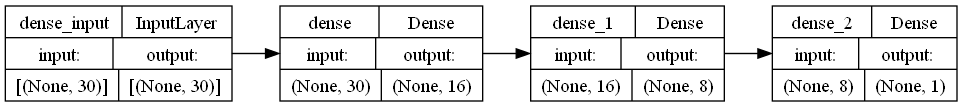

In [180]:
# plot
tf.keras.utils.plot_model(
    model_sequential, show_shapes=True, rankdir="LR", show_layer_names=True
)

In [181]:
history_seq = model_sequential.fit(
    train_pipe, epochs=20, validation_data=val_pipe, callbacks=[early_stopping]
)
history_seq_df = pd.DataFrame(history_seq.history)

history_seq_df.tail()

Epoch 1/20
   1/1666 [..............................] - ETA: 13:47 - loss: 1.3316 - accuracy: 0.4062

1666/1666 [==============================] - 2s 933us/step - loss: 0.4483 - accuracy: 0.7703 - val_loss: 0.3856 - val_accuracy: 0.8019
Epoch 2/20
1666/1666 [==============================] - 1s 865us/step - loss: 0.3480 - accuracy: 0.8398 - val_loss: 0.3103 - val_accuracy: 0.8760
Epoch 3/20
1666/1666 [==============================] - 1s 863us/step - loss: 0.2818 - accuracy: 0.8907 - val_loss: 0.2632 - val_accuracy: 0.8974
Epoch 4/20
1666/1666 [==============================] - 1s 863us/step - loss: 0.2454 - accuracy: 0.9038 - val_loss: 0.2364 - val_accuracy: 0.9006
Epoch 5/20
1666/1666 [==============================] - 1s 862us/step - loss: 0.2283 - accuracy: 0.9065 - val_loss: 0.2264 - val_accuracy: 0.9046
Epoch 6/20
1666/1666 [==============================] - 2s 928us/step - loss: 0.2158 - accuracy: 0.9117 - val_loss: 0.2145 - val_accuracy: 0.9153
Epoch 7/20
1666/1666 [==============================] - 2s 972us/step - loss: 0.2056 - accuracy: 0.9147 - val_loss: 0.2060 - val_accura

,loss,accuracy,val_loss,val_accuracy
15,0.180269,0.923854,0.186204,0.920258
16,0.179769,0.924042,0.192219,0.919658
17,0.178242,0.924060,0.188093,0.918156
18,0.176780,0.923685,0.186458,0.921310
19,0.176905,0.923798,0.197081,0.917405


Setelah dilakukan training dengan jumlah epoch 20, didapatkan nilai accuracy terbaik adalah 92.4%

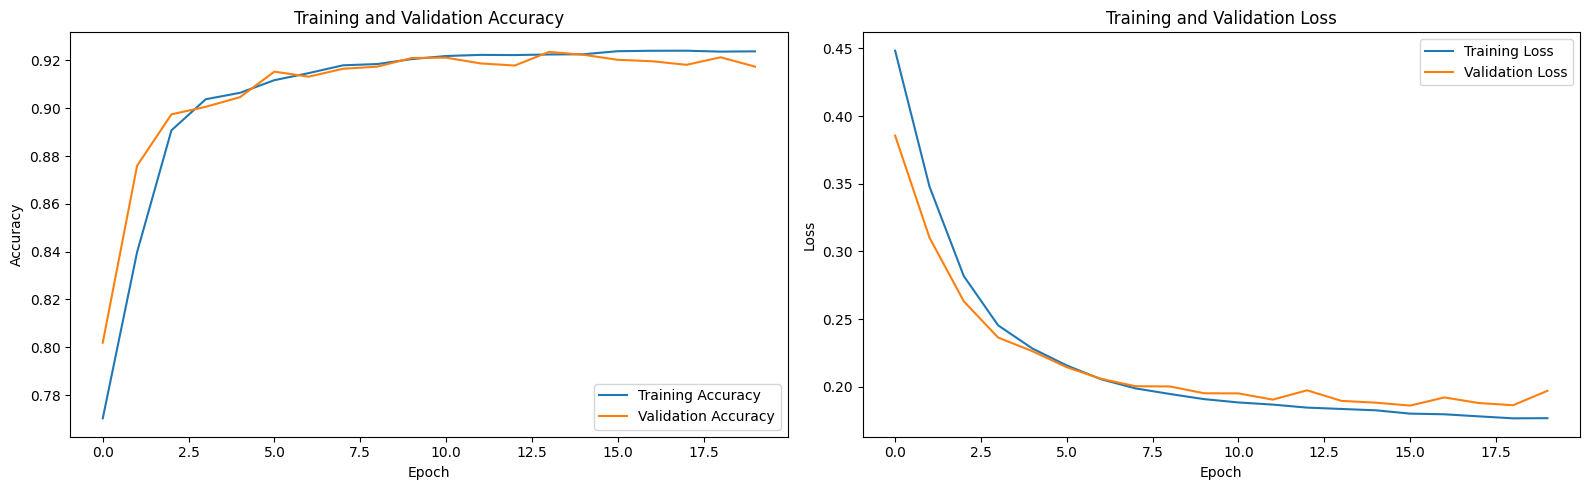

In [182]:
plt.figure(figsize=(16, 5))

# First subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history_seq_df["accuracy"], label="Training Accuracy")
plt.plot(history_seq_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Second subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history_seq_df["loss"], label="Training Loss")
plt.plot(history_seq_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()

Dapat terlihat bahwa model mulai convergence pada epoch sekitar 5-10 dan mulai stagnan seterusnya, hal ini menandakan bahwa model memiliki nilai yang cukup baik dengan akurasi diatas 94%

### Functional


In [183]:
# clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

Kemudian kita akan membuat sebuah model ANN dengan Functional API dengan 2 hidden layer dan 1 concate layer, dimana concate layer ini akan terhubung dengan hidden layer 2 dan input layer

In [184]:
input_layer = Input(shape=(30,))
hidden_layer_1 = Dense(
    16, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed)
)(input_layer)

hidden_layer_2 = Dense(
    8, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed)
)(hidden_layer_1)

concat_layer = concatenate([input_layer, hidden_layer_2])

output_layer = Dense(
    1, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal(seed)
)(concat_layer)

model_functional = Model(inputs=input_layer, outputs=output_layer)

# compile

model_functional.compile(
    loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics="accuracy"
)

model_functional.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 16)                   496       ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 8)                    136       ['dense[0][0]']               
                                                                                                  
 concatenate (Concatenate)   (None, 38)                   0         ['input_1[0][0]',             
                                                                     'dense_1[0][0]']         

Sehingga didapaktan jumlah neuron yang lebih banyak yaitu 671

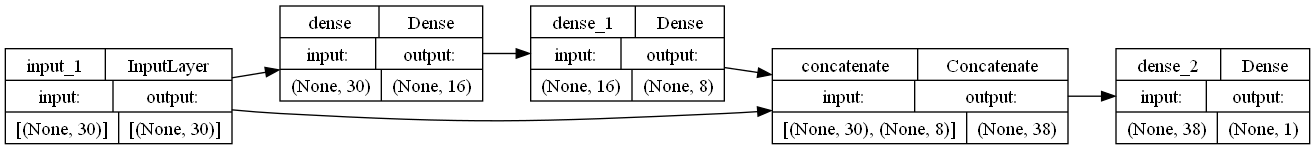

In [185]:
# plot
tf.keras.utils.plot_model(
    model_functional, show_shapes=True, rankdir="LR", show_layer_names=True
)

In [186]:
history_func = model_functional.fit(
    train_pipe, epochs=20, validation_data=val_pipe, batch_size=10
)

history_func_df = pd.DataFrame(history_func.history)

history_func_df.tail()

Epoch 1/20


1666/1666 [==============================] - 2s 1ms/step - loss: 0.4242 - accuracy: 0.7763 - val_loss: 0.3693 - val_accuracy: 0.8058
Epoch 2/20
1666/1666 [==============================] - 2s 899us/step - loss: 0.3498 - accuracy: 0.8350 - val_loss: 0.3341 - val_accuracy: 0.8569
Epoch 3/20
1666/1666 [==============================] - 1s 895us/step - loss: 0.3153 - accuracy: 0.8671 - val_loss: 0.2958 - val_accuracy: 0.8896
Epoch 4/20
1666/1666 [==============================] - 2s 904us/step - loss: 0.2791 - accuracy: 0.8944 - val_loss: 0.2682 - val_accuracy: 0.9006
Epoch 5/20
1666/1666 [==============================] - 1s 894us/step - loss: 0.2626 - accuracy: 0.9033 - val_loss: 0.2628 - val_accuracy: 0.8919
Epoch 6/20
1666/1666 [==============================] - 1s 889us/step - loss: 0.2566 - accuracy: 0.9054 - val_loss: 0.2580 - val_accuracy: 0.9037
Epoch 7/20
1666/1666 [==============================] - 1s 885us/step - loss: 0.2535 - accuracy: 0.9046 - val_loss: 0.2563 - val_accuracy

,loss,accuracy,val_loss,val_accuracy
15,0.183682,0.921714,0.185394,0.920859
16,0.183179,0.921920,0.185122,0.919357
17,0.181895,0.921714,0.195259,0.915753
18,0.181915,0.921995,0.183572,0.920709
19,0.180735,0.921789,0.188069,0.918606


Tetapi setelah kita lakukan training, nilai accuracy yang didapatkan tidak lebih baik dibandingkan menggunakan model sequential, dan hanya berada pada 92% accuracy

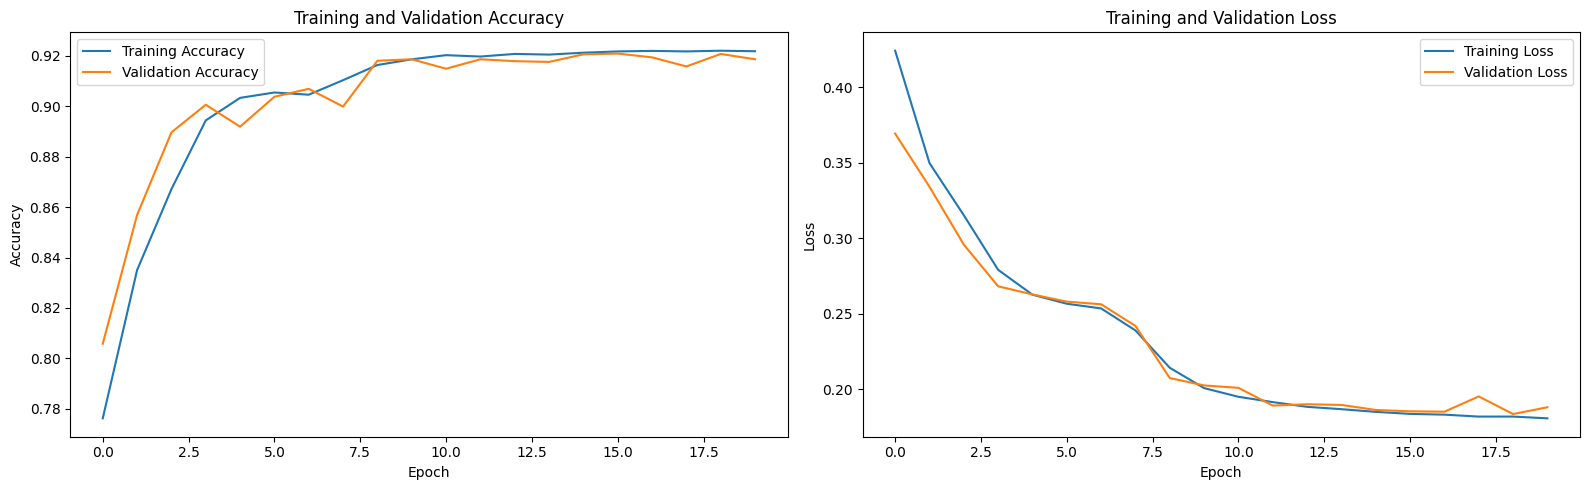

In [187]:
plt.figure(figsize=(16, 5))

# First subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history_func_df["accuracy"], label="Training Accuracy")
plt.plot(history_func_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Second subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history_func_df["loss"], label="Training Loss")
plt.plot(history_func_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()

Terlihat bahwa model ini lebih tidak stabik pada 10 epoch pertama dan mulai convergence setelah melewati 10 epoch

## 05 - Model Evaluation


Kemudian kita dapat melakukan evaluasi terhadap kedua model tersebut sebelum kita lakukan improvement

In [188]:
# predict test sequential
y_pred_seq = model_sequential.predict(X_test)

y_pred_seq = np.where(y_pred_seq > 0.65, 1, 0)

116/116 [==============================] - 0s 608us/step


In [191]:
# predict test functional
y_pred_func = model_functional.predict(X_test)

y_pred_func = np.where(y_pred_func > 0.65, 1, 0)

116/116 [==============================] - 0s 621us/step


In [215]:
print("Sequential Model")
print(classification_report(y_test, y_pred_seq))
print("\nFunctional Model")
print(classification_report(y_test, y_pred_func))

Sequential Model
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1672
           1       0.92      0.95      0.94      2028

    accuracy                           0.93      3700
   macro avg       0.93      0.93      0.93      3700
weighted avg       0.93      0.93      0.93      3700


Functional Model
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1672
           1       0.95      0.93      0.94      2028

    accuracy                           0.93      3700
   macro avg       0.93      0.94      0.93      3700
weighted avg       0.94      0.93      0.93      3700



Dari classification report, didapatkan informasi bahwa model sequential memiliki nilai recall yang lebih tinggi untuk prediksi data True, sedangkan model Functional lebih baik dalam prediksi data False, tetapi kedua model tersebut memiliki nilai accuracy yang mirip

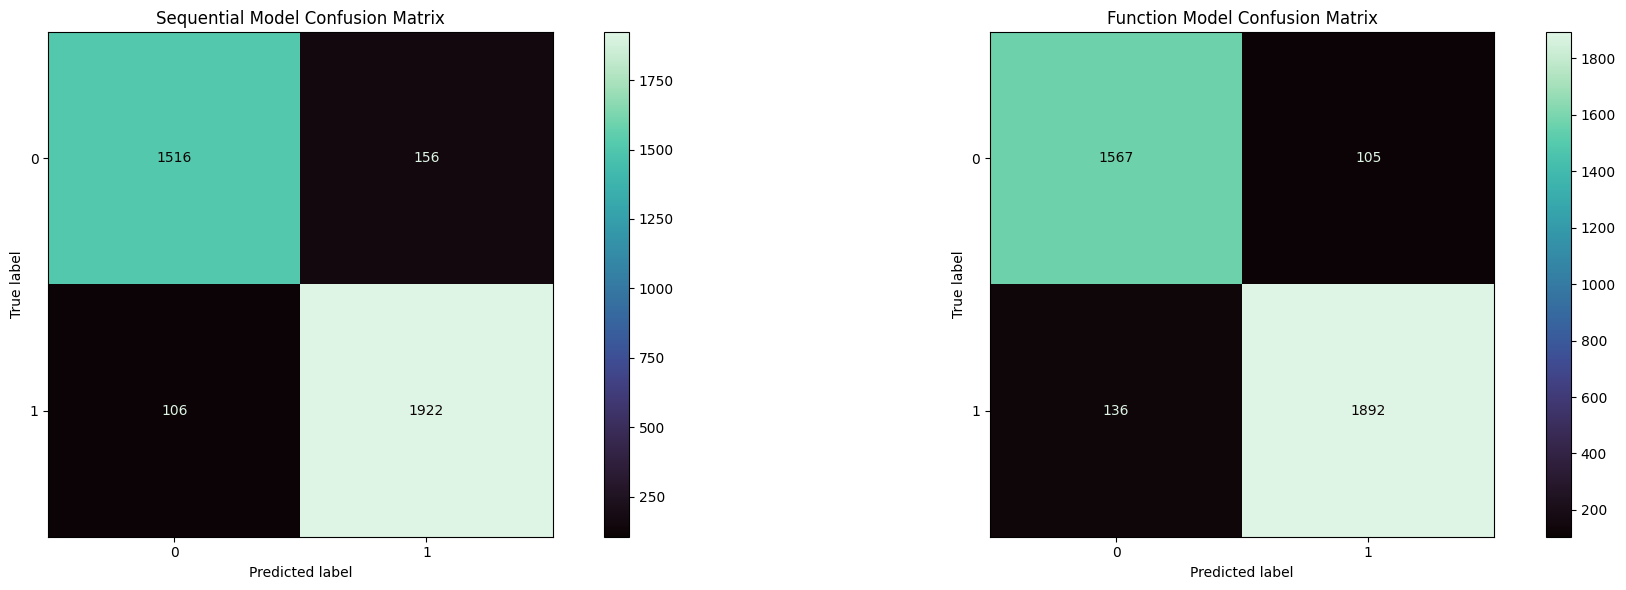

In [214]:
# define confusion matrix for both model
conf_matrix_func = confusion_matrix(y_true=y_test, y_pred=y_pred_func)
conf_matrix_seq = confusion_matrix(y_true=y_test, y_pred=y_pred_seq)

# create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# plot the first confusion matrix in the first subplot
disp_seq = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix_seq, display_labels=[0, 1]
)
disp_seq.plot(cmap="mako", ax=axs[0])
axs[0].set_title("Sequential Model Confusion Matrix")

# plot the second confusion matrix in the second subplot
disp_func = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix_func, display_labels=[0, 1]
)
disp_func.plot(cmap="mako", ax=axs[1])
axs[1].set_title("Function Model Confusion Matrix")

# adjust layout and display the plot
plt.tight_layout()
plt.show()

Dapat terlihat bahwa pada confusion matrix, model Sequential memprediksi data True lebih baik, dengan nilai false negative yang lebih sedikit, begitupula sebaliknya pada model Functional memiliki prediksi lebih baik pada data False dengan jumlah false positive lebih sedikit

## 06 - Model Improvement


Kemudian kita dapat melakukan improvement pada model, baik dengan menambahkan hidden layers ataupun menggunakan parameter yang berbeda

### Sequential - Improved


In [194]:
# clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

Pada improvement kali ini, kita akan tambahkan callback Reduce Learning Rate on Plateau, bertujuan agar model dapat mengurangi learngin rate saat terdapat stagnansi sehingga model lebih sensitif terhadap perubahan

In [195]:
reduce_lr = ReduceLROnPlateau(monitor="accuracy", factor=0.2, patience=5, min_lr=0)

early_stopping = EarlyStopping(
    monitor="accuracy", patience=10, restore_best_weights=True
)

Pada model sequential, kita tambahkan jumlah hidden layer menjadi 4, dengan jumlah neuron yang semakin kecil secara bertahap

In [196]:
model_sequential_improve = Sequential()

model_sequential_improve.add(
    Dense(
        16,
        activation="relu",
        kernel_initializer=tf.keras.initializers.HeNormal(seed),
        input_shape=(30,),
    )
)  # Hidden Layer 1

model_sequential_improve.add(
    Dense(8, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed))
)  # Hidden Layer 2

model_sequential_improve.add(
    Dense(4, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed))
)  # Hidden Layer 3

model_sequential_improve.add(
    Dense(2, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed))
)  # Hidden Layer 4

model_sequential_improve.add(
    Dense(
        1,
        activation="sigmoid",
        kernel_initializer=tf.keras.initializers.GlorotNormal(seed),
    )
)  # Output Layer

# compile
model_sequential_improve.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

model_sequential_improve.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                496       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 2)                 10        
                                                                 
 dense_4 (Dense)             (None, 1)                 3         
                                                                 
Total params: 681 (2.66 KB)
Trainable params: 681 (2.66 KB)
Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Didapatkan menambahkan parameter menjadi 681

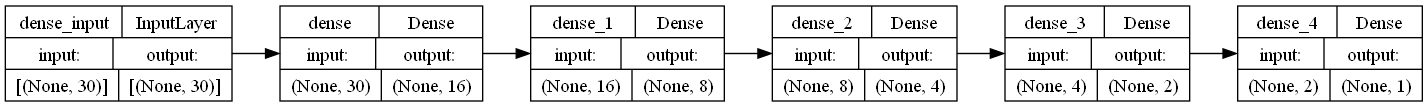

In [197]:
# plot
tf.keras.utils.plot_model(
    model_sequential_improve, show_shapes=True, rankdir="LR", show_layer_names=True
)

In [198]:
history_seq_improve = model_sequential_improve.fit(
    train_pipe,
    epochs=50,
    validation_data=val_pipe,
    callbacks=[early_stopping, reduce_lr],
)
history_seq_improve_df = pd.DataFrame(history_seq_improve.history)

history_seq_improve_df.tail()

Epoch 1/50


1666/1666 [==============================] - 3s 1ms/step - loss: 0.4338 - accuracy: 0.7746 - val_loss: 0.3749 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 2/50
1666/1666 [==============================] - 2s 1ms/step - loss: 0.3465 - accuracy: 0.8258 - val_loss: 0.3320 - val_accuracy: 0.8287 - lr: 0.0010
Epoch 3/50
1666/1666 [==============================] - 2s 1ms/step - loss: 0.2984 - accuracy: 0.8488 - val_loss: 0.2689 - val_accuracy: 0.8730 - lr: 0.0010
Epoch 4/50
1666/1666 [==============================] - 2s 1ms/step - loss: 0.2468 - accuracy: 0.8967 - val_loss: 0.2276 - val_accuracy: 0.9135 - lr: 0.0010
Epoch 5/50
1666/1666 [==============================] - 2s 1ms/step - loss: 0.2172 - accuracy: 0.9150 - val_loss: 0.2042 - val_accuracy: 0.9201 - lr: 0.0010
Epoch 6/50
1666/1666 [==============================] - 2s 1ms/step - loss: 0.2024 - accuracy: 0.9186 - val_loss: 0.1958 - val_accuracy: 0.9210 - lr: 0.0010
Epoch 7/50
1666/1666 [==============================] - 2s 1ms/step -

,loss,accuracy,val_loss,val_accuracy,lr
41,0.160020,0.932189,0.175187,0.925514,0.000008
42,0.159969,0.932396,0.175192,0.925815,0.000008
43,0.159951,0.932283,0.175210,0.925514,0.000008
44,0.159959,0.932171,0.175242,0.925664,0.000008
45,0.159965,0.932058,0.175228,0.925815,0.000008


Setelah melakukan training dengan epoch 50, didapatkan peningkatan accuracy menjadi 93.2% dari sebelumnya 92.4%

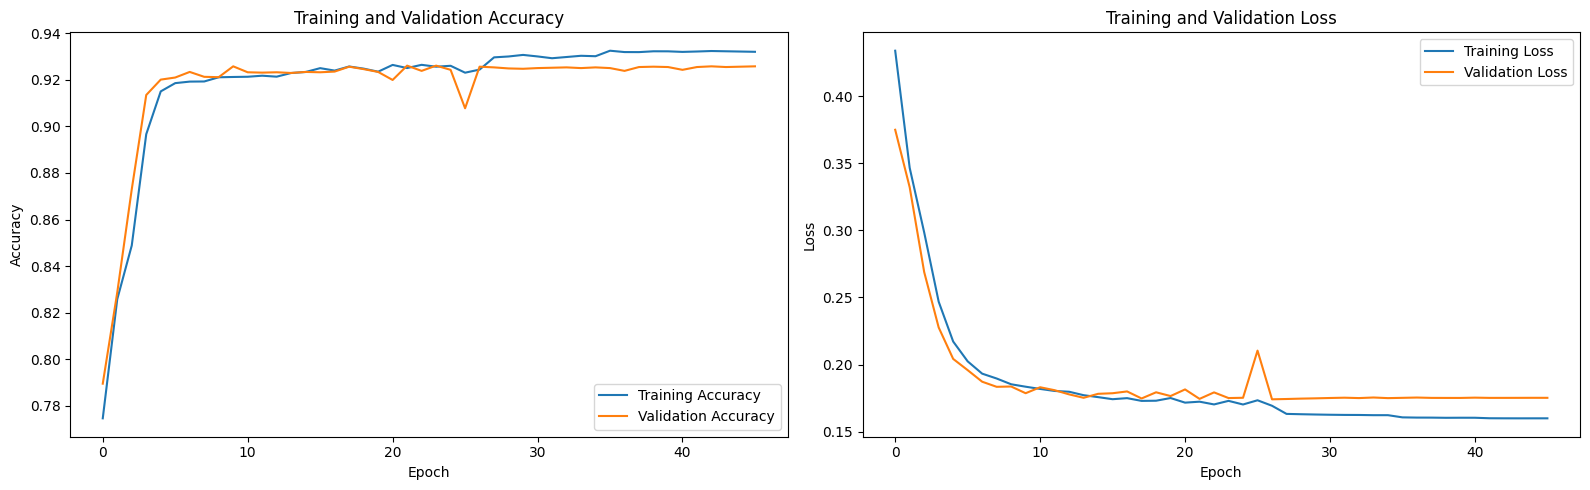

In [199]:
plt.figure(figsize=(16, 5))

# First subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history_seq_improve_df["accuracy"], label="Training Accuracy")
plt.plot(history_seq_improve_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Second subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history_seq_improve_df["loss"], label="Training Loss")
plt.plot(history_seq_improve_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()

Dapat terlihat juga pada plot bahwa model menjadi lebih konvergen pada epoch ke 30 dan seterusnya

Setelah itu kita dapat lakukan prediksi pada data test

In [200]:
# predict test
y_pred_seq_improve = model_sequential_improve.predict(X_test)

y_pred_seq_improve = np.where(y_pred_seq_improve > 0.65, 1, 0)

116/116 [==============================] - 0s 581us/step


### Functional - Improved


In [201]:
# clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

Untuk Functional Model, kita akan gunakan pendekatan berbeda dari sebelumnya, dimana kita akan menggunakan 5 hidden layer, dan terdapat lompatan setiap 2 hidden layer, contohnya pada hidden layer 1 yang dapat menuju ke hidden layer 2 ataupun hidden layer 3

In [202]:
input_layer = Input(shape=(30,))
hidden_layer_1 = Dense(
    16, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed)
)(input_layer)

hidden_layer_2 = Dense(
    8, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed)
)(hidden_layer_1)

hidden_layer_3 = concatenate([hidden_layer_1, hidden_layer_2])

hidden_layer_4 = Dense(
    8, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed)
)(hidden_layer_3)

concat_layer = concatenate([hidden_layer_3, hidden_layer_4])

output_layer = Dense(
    1, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal(seed)
)(concat_layer)

model_functional_improved = Model(inputs=input_layer, outputs=output_layer)

# compile

model_functional_improved.compile(
    loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics="accuracy"
)

model_functional_improved.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 16)                   496       ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 8)                    136       ['dense[0][0]']               
                                                                                                  
 concatenate (Concatenate)   (None, 24)                   0         ['dense[0][0]',               
                                                                     'dense_1[0][0]']         

Sehingga didapatkan nilai parameter yang jauh lebih banyak yaitu sebanyak 865

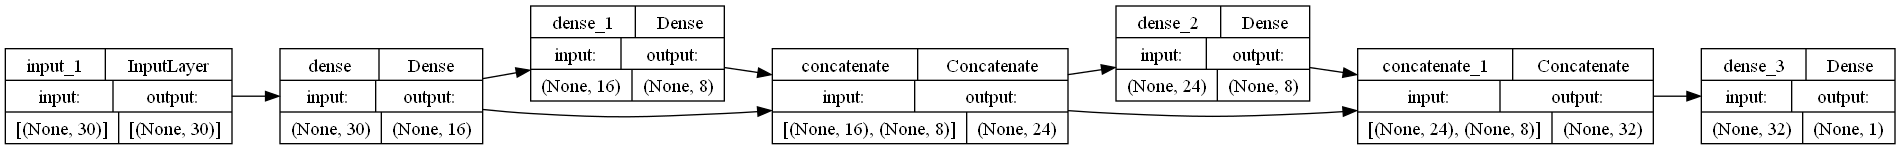

In [203]:
# plot
tf.keras.utils.plot_model(
    model_functional_improved, show_shapes=True, rankdir="LR", show_layer_names=True
)

In [204]:
history_func_improved = model_functional_improved.fit(
    train_pipe,
    epochs=50,
    validation_data=val_pipe,
    batch_size=10,
    callbacks=[early_stopping, reduce_lr],
)

history_func_improved_df = pd.DataFrame(history_func_improved.history)

history_func_improved_df.tail()

Epoch 1/50


1666/1666 [==============================] - 2s 1ms/step - loss: 0.4266 - accuracy: 0.7929 - val_loss: 0.3476 - val_accuracy: 0.8434 - lr: 0.0010
Epoch 2/50
1666/1666 [==============================] - 2s 998us/step - loss: 0.3193 - accuracy: 0.8593 - val_loss: 0.2840 - val_accuracy: 0.8814 - lr: 0.0010
Epoch 3/50
1666/1666 [==============================] - 2s 956us/step - loss: 0.2489 - accuracy: 0.9010 - val_loss: 0.2153 - val_accuracy: 0.9127 - lr: 0.0010
Epoch 4/50
1666/1666 [==============================] - 2s 994us/step - loss: 0.2102 - accuracy: 0.9136 - val_loss: 0.2001 - val_accuracy: 0.9162 - lr: 0.0010
Epoch 5/50
1666/1666 [==============================] - 2s 952us/step - loss: 0.1993 - accuracy: 0.9162 - val_loss: 0.1959 - val_accuracy: 0.9192 - lr: 0.0010
Epoch 6/50
1666/1666 [==============================] - 2s 931us/step - loss: 0.1916 - accuracy: 0.9175 - val_loss: 0.1904 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 7/50
1666/1666 [==============================] - 2s 

,loss,accuracy,val_loss,val_accuracy,lr
45,0.151600,0.935625,0.164998,0.931071,0.0002
46,0.150931,0.936808,0.164832,0.930921,0.0002
47,0.150694,0.936826,0.164715,0.929869,0.0002
48,0.150424,0.936658,0.165598,0.928818,0.0002
49,0.150376,0.936733,0.166034,0.930921,0.0002


Didapatkan pula nilai accuracy yang lebih baik yaitu 93.6% dibandingkan sebelumnya yaitu 92%

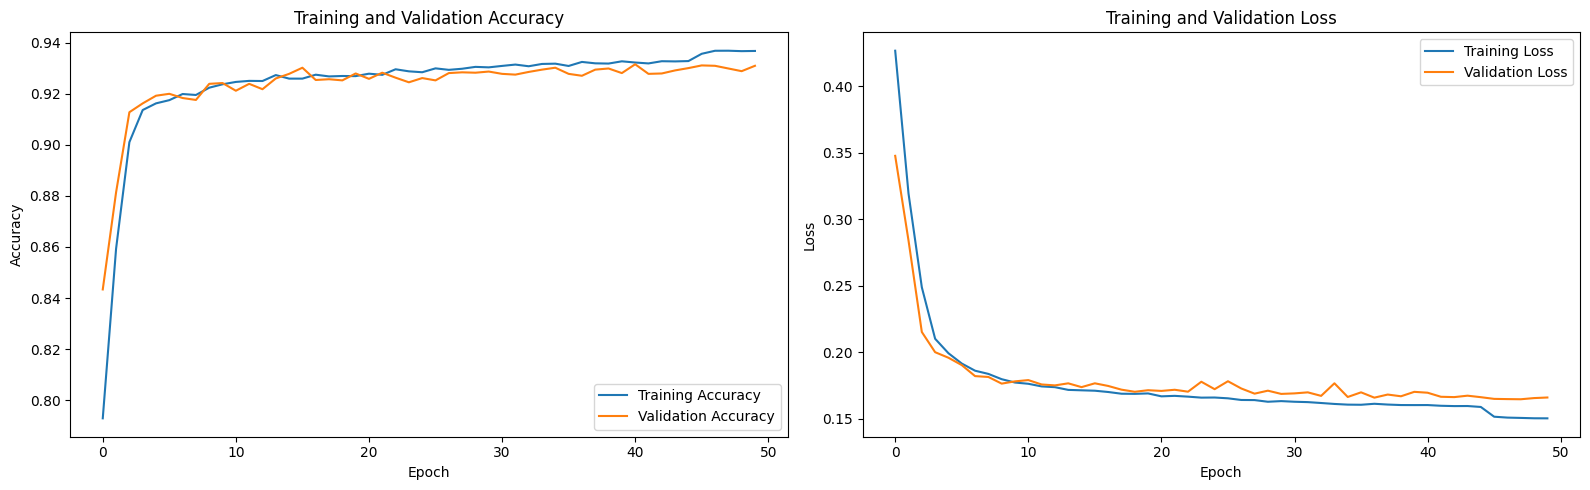

In [205]:
plt.figure(figsize=(16, 5))

# First subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history_func_improved_df["accuracy"], label="Training Accuracy")
plt.plot(history_func_improved_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Second subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history_func_improved_df["loss"], label="Training Loss")
plt.plot(history_func_improved_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()

Pada model functional, terlihat lebih stabil dibandingkan dengan model sequential

In [206]:
# predict test
y_pred_func_improve = model_functional_improved.predict(X_test)

y_pred_func_improve = np.where(y_pred_func_improve > 0.65, 1, 0)

116/116 [==============================] - 0s 601us/step


### Best Model Evaluation


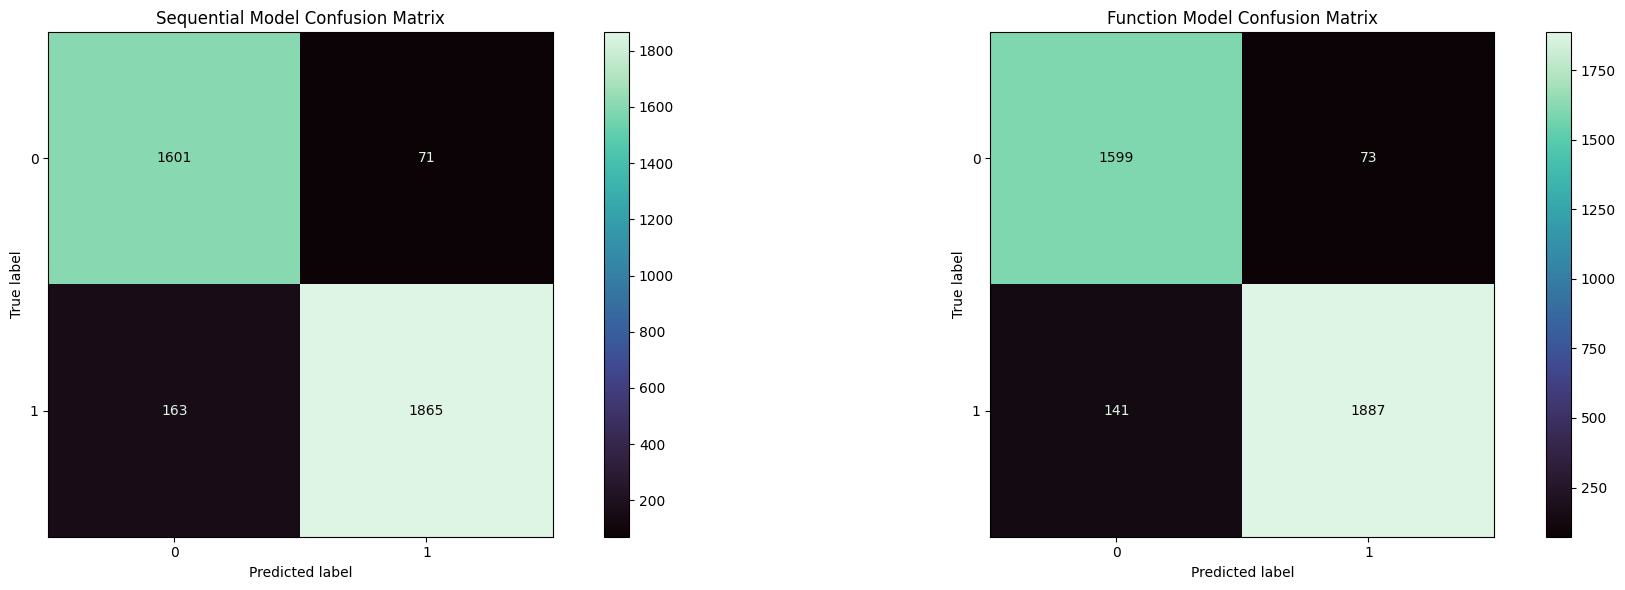

In [221]:
# define confusion matrix for both model
conf_matrix_func = confusion_matrix(y_true=y_test, y_pred=y_pred_func_improve)
conf_matrix_seq = confusion_matrix(y_true=y_test, y_pred=y_pred_seq_improve)

# create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# plot the first confusion matrix in the first subplot
disp_seq = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix_seq, display_labels=[0, 1]
)
disp_seq.plot(cmap="mako", ax=axs[0])
axs[0].set_title("Sequential Model Confusion Matrix")

# plot the second confusion matrix in the second subplot
disp_func = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix_func, display_labels=[0, 1]
)
disp_func.plot(cmap="mako", ax=axs[1])
axs[1].set_title("Function Model Confusion Matrix")

# adjust layout and display the plot
plt.tight_layout()
plt.show()

Kita dapat lihat bahwa pada kedua model terjadi penurunan nilai pada False Negative dan False positive, ini menandakan bahwa model bekerja lebih baik setelah dilakukan improvement

In [208]:
print("------------------Sequential Improved------------------")
print(classification_report(y_test, y_pred_seq_improve))
print("\n------------------Functional Improved------------------")
print(classification_report(y_test, y_pred_func_improve))

------------------Sequential Improved------------------
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1672
           1       0.96      0.92      0.94      2028

    accuracy                           0.94      3700
   macro avg       0.94      0.94      0.94      3700
weighted avg       0.94      0.94      0.94      3700


------------------Functional Improved------------------
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1672
           1       0.96      0.93      0.95      2028

    accuracy                           0.94      3700
   macro avg       0.94      0.94      0.94      3700
weighted avg       0.94      0.94      0.94      3700



Dari classification report didapatkan peningkatan pada kedua model, dan pada model Functional terlihat secara overall bahwa model memiliki performa yang lebih baik, sehingga model ini yang akan kita gunakan sebagai model final

## 07 - Model Saving


Kemudian kita dapat lakukan saving pada model untuk dilakukan inferencing nantinya

In [209]:
# save column transformer
with open("column_transformer.pkl", "wb") as file_1:
    pickle.dump(col_transformers, file_1)

In [210]:
# freeze model and save model
model_functional.trainable = False
model_functional.save("functional_model.keras")

## 08 - Model Inferencing


In [211]:
# load model
with open("column_transformer.pkl", "rb") as file_1:
    column_transfomer_model = pickle.load(file_1)

functional_ann_model = load_model("./functional_model.keras")

In [212]:
data_inf = [{
        "age": 62,
        "region_category": "Town",
        "membership_category": "No Membership",
        "joined_through_referral": "Yes",
        "preferred_offer_types": "Credit/Debit Card Offers",
        "medium_of_operation": "Both",
        "internet_option": "Wi-Fi",
        "days_since_last_login": 17,
        "avg_time_spent": 52.17,
        "avg_transaction_value": 5751.99,
        "avg_frequency_login_days": 20.0,
        "points_in_wallet": 103.69272559078036,
        "used_special_discount": "Yes",
        "offer_application_preference": "No",
        "past_complaint": "No",
        "complaint_status": "Not Applicable",
        "feedback": "Negative",
}]

data_inf = pd.DataFrame(data_inf)

data_inf

,age,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
0,62,Town,No Membership,Yes,Credit/Debit Card Offers,Both,Wi-Fi,17,52.17,5751.99,20.0,103.692726,Yes,No,No,Not Applicable,Negative


In [213]:
data_inf_transform = column_transfomer_model.transform(data_inf)
y_pred_inf = functional_ann_model.predict(data_inf_transform)
y_pred_inf = np.where(y_pred_inf >= 0.65, 1, 0)

if y_pred_inf[0] == 1:
    print("Customer potentially Churn")
else:
    print("Customer potentially Don't Churn")

1/1 [==============================] - 0s 59ms/step
Customer potentially Churn


## 09 - Kesimpulan

Dari ke-empat pemodelan tersebut, didapatkan model terbaik sebagai berikut:
* ANN Functional API
* 5-Hidden Layer dengan skipping layer tiap 2 hidden layer
* Callback Early Stopping, dan Reduce LR on Plateau
* Epoch 50

In [218]:
print(classification_report(y_true=y_test, y_pred=y_pred_func_improve))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1672
           1       0.96      0.93      0.95      2028

    accuracy                           0.94      3700
   macro avg       0.94      0.94      0.94      3700
weighted avg       0.94      0.94      0.94      3700



Model tersebut memiliki performa yang sangat baik dengan nilai recall yang tinggi pada data Positive dan Negative mencapai 96% dan 93%, dengan nilai akurasi mencapai 94% dari 3700 prediksi

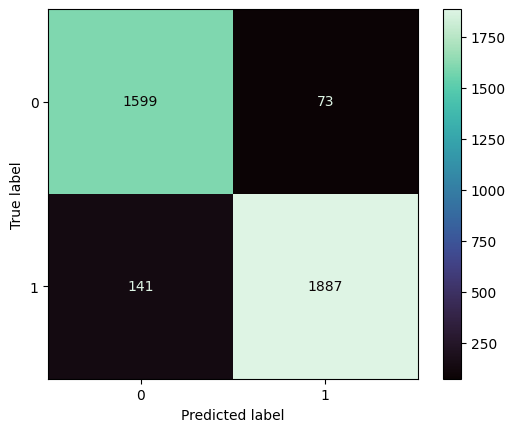

In [222]:
ConfusionMatrixDisplay(conf_matrix_func).plot(cmap="mako")

Dan juga confusion matrix yang bagus dengan nilai prediksi false positive 73 data dan false negative sebanyak 141 data

Dapat ditarik kesimpulan bahwa model ini sudah good fit, dan dapat digunakan sebagai acuan bagi HaiMeds untuk menentukan apakah peengguna berpotensi churn atau tidak, sehingga disarankan untuk memberikan tindakan sebagai berikut:
* Pada pelanggan yang diprediksi Churn dapat diberikan insentif seperti diskon atau promo pada saat bertransaksi menggunakan aplikasi HaiMeds
* Untuk pelanggan yang tidak diprediksi Churn, dapat diberikan program loyalitas agar pengguna tetap menggunakan aplikasi HaiMeds